# INCLUDE AND INSTALL SECTION WITH IMPORT AND GLOBAL VARIABLES

In [2]:
import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import pixiedust
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SQLContext
from mpl_toolkits import mplot3d

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Pixiedust database opened successfully


In [3]:
# The code was removed by Watson Studio for sharing.

# THIS IS THE FIRST SECTION IN WICH I INGEST ORIGINAL CSV DATA AND AS RESULT I BUILD CSV RESHAPED

Shape data in "77_cancer_proteomes_CPTAC_itraq.csv" from colum mode to raw mode.

The data are the raw exported in CSV format and loaded in a DashDB cloud instance (jdbc:db2://dashdb-entry-yp-dal09-10.services.dal.bluemix.net:50000/BLUDB:retrieveMessagesFromServerOnGetMessage=true) in a table with following DDL:

CREATE TABLE "DASH13540"."BREASTCANCER_GENOMES" (<br>
		"RefSeq_accession_number" CHAR(100 OCTETS),<br>
		"gene_symbol" CHAR(20 OCTETS), <br>
		"gene_name" CHAR(250 OCTETS), <br>
		"Patient" CHAR(28 OCTETS), <br>
		"Value" DOUBLE, <br>
		"Gene" CHAR(250 OCTETS) NOT NULL, <br>
		"Patient_ID" CHAR(24 OCTETS) NOT NULL<br>
	)<br>
	ORGANIZE BY COLUMN<br>
	DATA CAPTURE NONE;<br>

With following SQL i verify data duplication:

select distinct "Patient_ID" from "DASH13540"."BREASTCANCER_GENOMES" group by "Gene", "Patient_ID" having count(*)>1;

I observer that 3 Patient_ID (AO-A12D, C8-A131, A0-A12B) have duplicated column in term of proteomes values having a single status record in Patient data.

Consquently i delete those column generating a new csv input file "77_cancer_proteomes_CPTAC_itraq_NODouble.csv" and again a reshaped it

I also observed that last 3 column in data matrix refer to heatly patient (without record in patient statis data). So i change column in HEALTY1,2,3 and i add those 3 pseudo patient to patient record.

Again i create a new csv file "clinical_data_breast_cancer_withHealty.csv" and i use this

In notebook i maintain all passages

In [4]:
# The code was removed by Watson Studio for sharing.

,RefSeq_accession_number,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
0,NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
1,NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
2,NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
3,NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
4,NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [5]:
body = client_8a4fc8dc8bf54832ab62f63af0c03772.get_object(Bucket='breastcancerproteomes-donotdelete-pr-zmcmbnmwpo1wza',Key='clinical_data_breast_cancer.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

patientData = pd.read_csv(body)
patientData.sort_values(by=['Complete TCGA ID'],inplace=True)
patientData.head()

,Complete TCGA ID,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
1,TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
7,TCGA-A2-A0D0,FEMALE,60,Negative,Negative,Negative,T2,T_Other,N0,Negative,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
28,TCGA-A2-A0D1,FEMALE,76,Negative,Negative,Positive,T2,T_Other,N0,Negative,...,HER2-enriched,-6,-2,1,3,Basal,1,1,2,2
10,TCGA-A2-A0D2,FEMALE,45,Negative,Negative,Negative,T2,T_Other,N0,Negative,...,Basal-like,-12,-13,4,5,Basal,3,2,2,2
31,TCGA-A2-A0EQ,FEMALE,64,Negative,Negative,Positive,T2,T_Other,N0,Negative,...,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1


In [6]:
# Using MELT panda's function i reshaped original CSV data matrix into a tabular format to use DashDb & SPARK
reshapedData=pd.melt(orgData,id_vars=["RefSeq_accession_number","gene_symbol","gene_name"],var_name="Patient",value_name="Value")
reshapedData.head()

,RefSeq_accession_number,gene_symbol,gene_name,Patient,Value
0,NP_958782,PLEC,plectin isoform 1,AO-A12D.01TCGA,1.096131
1,NP_958785,NaN,plectin isoform 1g,AO-A12D.01TCGA,1.111370
2,NP_958786,PLEC,plectin isoform 1a,AO-A12D.01TCGA,1.111370
3,NP_000436,NaN,plectin isoform 1c,AO-A12D.01TCGA,1.107561
4,NP_958781,NaN,plectin isoform 1e,AO-A12D.01TCGA,1.115180


In [7]:
# I add two new column: GENE obtained merging proteomes information and PATIENT_ID reformating the patient code in the same format of patient data original CSV. Note usage of fillna
reshapedData["Gene"]=reshapedData["RefSeq_accession_number"].fillna('#')+"-"+reshapedData["gene_symbol"].fillna('#')+" ("+reshapedData["gene_name"].fillna('#')+")"
reshapedData["Patient_ID"]="TCGA-" + reshapedData["Patient"].str.slice(0,7)
reshapedData.head()

,RefSeq_accession_number,gene_symbol,gene_name,Patient,Value,Gene,Patient_ID
0,NP_958782,PLEC,plectin isoform 1,AO-A12D.01TCGA,1.096131,NP_958782-PLEC (plectin isoform 1),TCGA-AO-A12D
1,NP_958785,NaN,plectin isoform 1g,AO-A12D.01TCGA,1.111370,NP_958785-# (plectin isoform 1g),TCGA-AO-A12D
2,NP_958786,PLEC,plectin isoform 1a,AO-A12D.01TCGA,1.111370,NP_958786-PLEC (plectin isoform 1a),TCGA-AO-A12D
3,NP_000436,NaN,plectin isoform 1c,AO-A12D.01TCGA,1.107561,NP_000436-# (plectin isoform 1c),TCGA-AO-A12D
4,NP_958781,NaN,plectin isoform 1e,AO-A12D.01TCGA,1.115180,NP_958781-# (plectin isoform 1e),TCGA-AO-A12D


In [8]:
# Number of records original
reshapedData.shape[0]

1041899

In [9]:
#verify what separator to use in out CSV to avoid further db load problem. I use ; insted , that is used in Gene field
coma_count=reshapedData['Gene'].str.contains(';').sum()
print (coma_count)

0


In [10]:
# I save gene data reshaped in CSV format with ; separator directlu in Cloud Object Storage
project.save_data(data=reshapedData.to_csv(index=False, sep=';', encoding='utf-8'),file_name='Reshaped_data1.csv',overwrite=True)

{'asset_id': '25330465-2ad0-4e1b-8de1-fd154128a0f6',
 'bucket_name': 'breastcancerproteomes-donotdelete-pr-zmcmbnmwpo1wza',
 'file_name': 'Reshaped_data1.csv',
 'message': 'File Reshaped_data1.csv has been written successfully to the associated OS'}

Now i made all SQL stuff to verify data cleaning as stated at section begin. As result i modify original CSV data and the i reimport and reshape those new non duplicated data

In [11]:
# I reimport cleaned CSV; observe now i have only 80 columns.

body = client_8a4fc8dc8bf54832ab62f63af0c03772.get_object(Bucket='breastcancerproteomes-donotdelete-pr-zmcmbnmwpo1wza',Key='77_cancer_proteomes_CPTAC_itraq_NODouble.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

nodoubled_data = pd.read_csv(body)
nodoubled_data.head()

,RefSeq_accession_number,gene_symbol,gene_name,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AN-A04A.05TCGA,...,AR-A0TT.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,HEALTY1,HEALTY2,HEALTY3
0,NP_958782,PLEC,plectin isoform 1,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,0.384588,...,-0.511421,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
1,NP_958785,NaN,plectin isoform 1g,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,0.371393,...,-0.526067,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
2,NP_958786,PLEC,plectin isoform 1a,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,0.371393,...,-0.526067,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
3,NP_000436,NaN,plectin isoform 1c,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,0.377990,...,-0.533389,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
4,NP_958781,NaN,plectin isoform 1e,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,0.374692,...,-0.529728,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [12]:
# Same reshape and new column building as before BUT without duplicate or non clear data
reshapedData1=pd.melt(nodoubled_data,id_vars=["RefSeq_accession_number","gene_symbol","gene_name"],var_name="Patient",value_name="Value")
reshapedData1["Gene"]=reshapedData1["RefSeq_accession_number"].fillna('#')+"-"+reshapedData1["gene_symbol"].fillna('#')+" ("+reshapedData1["gene_name"].fillna('#')+")"
reshapedData1["Patient_ID"]="TCGA-" + reshapedData1["Patient"].str.slice(0,7)
reshapedData1.head()

,RefSeq_accession_number,gene_symbol,gene_name,Patient,Value,Gene,Patient_ID
0,NP_958782,PLEC,plectin isoform 1,BH-A18Q.02TCGA,0.195341,NP_958782-PLEC (plectin isoform 1),TCGA-BH-A18Q
1,NP_958785,NaN,plectin isoform 1g,BH-A18Q.02TCGA,0.215413,NP_958785-# (plectin isoform 1g),TCGA-BH-A18Q
2,NP_958786,PLEC,plectin isoform 1a,BH-A18Q.02TCGA,0.215413,NP_958786-PLEC (plectin isoform 1a),TCGA-BH-A18Q
3,NP_000436,NaN,plectin isoform 1c,BH-A18Q.02TCGA,0.205377,NP_000436-# (plectin isoform 1c),TCGA-BH-A18Q
4,NP_958781,NaN,plectin isoform 1e,BH-A18Q.02TCGA,0.215413,NP_958781-# (plectin isoform 1e),TCGA-BH-A18Q


In [13]:
# Number of records without double patients and nont clear situation coding
reshapedData1.shape[0]

966581

In [14]:
# And at the end i save data again in CSV format with ; separator
project.save_data(data=reshapedData1.to_csv(index=False, sep=';', encoding='utf-8'),file_name='Reshaped_data_nodouble.csv',overwrite=True)

{'asset_id': '46644faf-3fe6-4479-9a86-f11cc7cdbefc',
 'bucket_name': 'breastcancerproteomes-donotdelete-pr-zmcmbnmwpo1wza',
 'file_name': 'Reshaped_data_nodouble.csv',
 'message': 'File Reshaped_data_nodouble.csv has been written successfully to the associated OS'}

At the end i export CSV data from Cloud Object Storage and reimport not doubled/clean data in "DASH13540"."BREASTCANCER_GENOMES"

# Figurative section to remember actions made in DASH DB 

I import resulting csv from reshing and normalizafion phase in db2 tables. Then i define some decoding tables (exposed in following section) to create the base views (sql definition follow) to execute cross correlation analisys.

In [15]:
# The code was removed by Watson Studio for sharing.

+--------------------+----+
|          AJCC Stage|AJCC|
+--------------------+----+
|NO                  |   0|
|Stage IB            |   3|
|Stage III           |   7|
|Stage IIIC          |  10|
|Stage IIB           |   6|
|Stage I             |   1|
|Stage IIA           |   5|
|Stage IA            |   2|
|Stage II            |   4|
|Stage IV            |  11|
|Stage IIIA          |   8|
|Stage IIIB          |   9|
+--------------------+----+



In [16]:
rppaDecode= spark.read.jdbc(properties_dcfad1aea99e49d0abc14ecf6afa82b4['jdbcurl'], table='DASH13540.BREASTCANCERRPPADECODE', properties=properties_dcfad1aea99e49d0abc14ecf6afa82b4)
rppaDecode.show()

+-------------+----+
|RPPA Clusters|RPPA|
+-------------+----+
| NO          |   0|
| LumA        |   1|
| X           |   7|
| LumA/B      |   2|
| Her2        |   3|
| ReacII      |   4|
| ReacI       |   5|
| Basal       |   6|
+-------------+----+



Follow the definition of the view i use to acces do nodoubled clean data

>*select x."Gene" as GENE,
        x."Patient_ID" AS PATIENT_ID,
        x."Value" AS VELUE
   from "DASH13540"."BREASTCANCER_GENOMES" as x*

I also loaded Patient data __(from a cleane CSV excluding doubled case)__ in following table __"DASH13540"."BREASTCANCER_PATIENTS"__:<br>
> CREATE TABLE "DASH13540"."BREASTCANCER_PATIENTS" ( <br>
		"Complete TCGA ID" CHAR(24 OCTETS) NOT NULL, <br>
		"Gender" CHAR(12 OCTETS), <br>
		"Age at Initial Pathologic Diagnosis" SMALLINT, <br>
		"ER Status" CHAR(26 OCTETS), <br>
		"PR Status" CHAR(16 OCTETS), <br>
		"HER2 Final Status" CHAR(18 OCTETS), <br>
		"Tumor" CHAR(4 OCTETS), <br>
		"Tumor--T1 Coded" CHAR(14 OCTETS), <br>
		"Node" CHAR(4 OCTETS), <br>
		"Node-Coded" CHAR(16 OCTETS), <br>
		"Metastasis" CHAR(4 OCTETS), <br>
		"Metastasis-Coded" CHAR(16 OCTETS), <br>
		"AJCC Stage" CHAR(20 OCTETS), <br>
		"Converted Stage" CHAR(26 OCTETS), <br>
		"Survival Data Form" CHAR(20 OCTETS), <br>
		"Vital Status" CHAR(16 OCTETS), <br>
		"Days to Date of Last Contact" SMALLINT, <br>
		"Days to date of Death" CHAR(8 OCTETS), <br>
		"OS event" SMALLINT, <br>
		"OS Time" SMALLINT, <br>
		"PAM50 mRNA" CHAR(26 OCTETS), <br>
		"SigClust Unsupervised mRNA" SMALLINT, <br>
		"SigClust Intrinsic mRNA" SMALLINT, <br>
		"miRNA Clusters" SMALLINT, <br>
		"methylation Clusters" SMALLINT, <br>
		"RPPA Clusters" CHAR(12 OCTETS), <br>
		"CN Clusters" SMALLINT, <br>
		"Integrated Clusters (with PAM50)" SMALLINT, <br>
		"Integrated Clusters (no exp)" SMALLINT,<br> 
		"Integrated Clusters (unsup exp)" SMALLINT<br>
	)<br>
	ORGANIZE BY COLUMN<br>
	DATA CAPTURE NONE;<br>


Follow sql view __"DASH13540"."BREASTCANCERPATIENTSFORCORRELATIONANALYSIS"__ built over reshaped data to decode patients caracteristics declare in string
form. To execute cross correlationanalisys i need those aspect as numeric.

>CREATE VIEW "DASH13540"."BREASTCANCERPATIENTSFORCORRELATIONANALYSIS" ("PATIENT_ID", "SEX", "AGE", "TUMOR_TYPE", "METASTASIS_TYPE", "AJCC_CODE", "VITAL_STATUS", "ER_STATUS", "PR_STSTUS", <br>"HER2_STATUS", "NODE_TYPE", "RPPA_CODE") AS <br>
SELECT x."Complete TCGA ID" AS PATIENT_ID, <br>
  case x."Gender"<br>
  WHEN 'FEMALE' THEN 1<br>
  WHEN 'MALE' then 0<br>
  end as SEX, <br>
  x."Age at Initial Pathologic Diagnosis" as AGE,<br>
  CAST(Right(trim(x."Tumor"),1) AS INT) AS TUMOR_TYPE, <br>
  CAST(Right(trim(x."Metastasis"),1) AS INT) AS METASTASIS_TYPE, <br>
  y.AJCC as AJCC_CODE,<br>
  case x."Vital Status"<br>
  WHEN 'LIVING' THEN 1<br>
  WHEN 'DECEASED' then 0<br>
  end as VITAL_STATUS, <br>
  case x."ER Status" <br>
  WHEN 'NO' THEN 0<br>
  WHEN 'Positive' THEN 1<br>
  WHEN 'Negative' THEN 2<br>
  WHEN 'Indeterminate' THEN 2<br>
  end as ER_STATUS,<br>
  case x."PR Status" <br>
  WHEN 'NO' THEN 0<br>
  WHEN 'Positive' THEN 1<br>
  WHEN 'Negative' THEN 2<br>
  end as PR_STSTUS,<br>
  case x."HER2 Final Status" <br>
  WHEN 'NO' THEN 0<br>
  WHEN 'Positive' THEN 1<br>
  WHEN 'Negative' THEN 2<br>
  WHEN 'Equivocal' THEN 2<br>
  end as HER2_STATUS,<br>
  case x."Node" <br>
  WHEN 'NO' THEN 4<br>
  WHEN 'N0' THEN 0<br>
  WHEN 'N1' THEN 1<br>
  WHEN 'N2' THEN 2<br>
  WHEN 'N3' THEN 3<br>
  end as NODE_TYPE,<br>
  z.RPPA as RPPA_CODE<br> 
  FROM DASH13540.BREASTCANCER_PATIENTS AS x,<br>
       DASH13540.BREASTCANCERAJCCDEcode as Y,<br>
       DASH13540.BREASTCANCERRPPADEcode as z<br>
  where x."AJCC Stage"=y."AJCC Stage"<br>
    and x."RPPA Clusters"=z."RPPA Clusters";

At the end i use the __"DASH13540"."BREASTCANCERDATA"__ as source for further analisys. Follow SQL definition 

CREATE VIEW "DASH13540"."BREASTCANCERDATA" ("GENE", "PATIENT_ID", "VELUE") AS
select x."Gene" as GENE,
        x."Patient_ID" AS PATIENT_ID,
        x."Value" AS VELUE
   from "DASH13540"."BREASTCANCER_GENOMES" as x;

# Restart phyton processing. Follow cross correlationa analisys and data filtering.

## First i normalize data both for proteomes value and for patients caracteristics

With normalization i intend the process for which i substitute the absolute parameter value with a floating point number calculated as *__[average(parameter_value)-parameter_value]/std(parameter_vale)__* over al GENE data across patients

### First proteomes normalization

In [17]:
#I read from DashDb data cleaned and not doubled
data_df_2 = spark.read.jdbc(properties_dcfad1aea99e49d0abc14ecf6afa82b4['jdbcurl'], table='DASH13540.BREASTCANCERDATA', properties=properties_dcfad1aea99e49d0abc14ecf6afa82b4)
data_df_2.show(5)

+--------------------+--------------------+--------------------+
|                GENE|          PATIENT_ID|               VELUE|
+--------------------+--------------------+--------------------+
|NP_659464-KIF6 (k...|TCGA-BH-A18Q     ...|-0.43693651899999997|
|NP_078980-KIF16B ...|TCGA-BH-A18Q     ...|        -2.169844323|
|NP_055889-KIF1B (...|TCGA-BH-A18Q     ...|        -0.045526841|
|NP_071396-KIF13A ...|TCGA-BH-A18Q     ...|        -0.948779943|
|NP_001099038-KIF1...|TCGA-BH-A18Q     ...|        -0.975542998|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [18]:
#convert to pandas to use pixyedust in visualization and verify count
proteamoesValueNOTNormalized=data_df_2.toPandas()
proteamoesValueNOTNormalized.shape[0]

966581

In [19]:
#display row istogram distribution of values
display(proteamoesValueNOTNormalized)

In [20]:
# I create a temporary local spark table to use Spark SQL for data normalization
data_df_2.createOrReplaceTempView("genomedata")

In [21]:
# I execute the Spark SQL normalization 
normalizedGeneData = spark.sql("SELECT x.GENE, \
                                       x.PATIENT_ID , \
                                       ((select avg(y.VELUE) from GENOMEDATA as Y where y.GENE = x.GENE group by y.GENE) - x.VELUE)/ \
                                        (select stddev(k.VELUE) from GENOMEDATA as k where  k.GENE = x.GENE group by k.GENE) as NORMVALUE \
                                from GENOMEDATA as x")
normalizedGeneData.show()

+--------------------+--------------------+--------------------+
|                GENE|          PATIENT_ID|           NORMVALUE|
+--------------------+--------------------+--------------------+
|NP_000167-NR3C1 (...|TCGA-C8-A12L     ...|  0.3496893372478091|
|NP_000167-NR3C1 (...|TCGA-A2-A0CM     ...|-0.24259161565258688|
|NP_000167-NR3C1 (...|TCGA-AR-A0U4     ...| 0.28078309166519444|
|NP_000167-NR3C1 (...|TCGA-A7-A13F     ...| -0.5110325653717807|
|NP_000167-NR3C1 (...|TCGA-C8-A138     ...|  0.8132174938464466|
|NP_000167-NR3C1 (...|TCGA-D8-A142     ...|  0.1515407406873719|
|NP_000167-NR3C1 (...|TCGA-C8-A134     ...|-0.31433643075861006|
|NP_000167-NR3C1 (...|TCGA-AR-A1AV     ...| -1.1762712530528232|
|NP_000167-NR3C1 (...|TCGA-A2-A0SX     ...|  -1.646701627581156|
|NP_000167-NR3C1 (...|TCGA-AR-A0TR     ...|   2.003451502878629|
|NP_000167-NR3C1 (...|TCGA-A8-A09G     ...|    0.80122706023031|
|NP_000167-NR3C1 (...|TCGA-C8-A12V     ...| -1.3948874728962022|
|NP_000167-NR3C1 (...|TCG

In [22]:
# convert to pandas for pixiedust visualization
normalizedGeneDataPandas= normalizedGeneData.toPandas()
normalizedGeneDataPandas.shape[0]

966581

In [23]:
display(normalizedGeneDataPandas)

### Follow normalization of decoded patient data

In [24]:
#i connect with patients decoded data
patientsDecoded = spark.read.jdbc(properties_dcfad1aea99e49d0abc14ecf6afa82b4['jdbcurl'], table='DASH13540.BREASTCANCERPATIENTSFORCORRELATIONANALYSIS', properties=properties_dcfad1aea99e49d0abc14ecf6afa82b4)
patientsDecoded.show()


+--------------------+---+---+----------+---------------+---------+------------+---------+---------+-----------+---------+---------+
|          PATIENT_ID|SEX|AGE|TUMOR_TYPE|METASTASIS_TYPE|AJCC_CODE|VITAL_STATUS|ER_STATUS|PR_STSTUS|HER2_STATUS|NODE_TYPE|RPPA_CODE|
+--------------------+---+---+----------+---------------+---------+------------+---------+---------+-----------+---------+---------+
|TCGA-HEALTY1     ...|  1| 45|         0|              0|        0|           1|        0|        0|          0|        4|        0|
|TCGA-HEALTY2     ...|  1| 45|         0|              0|        0|           1|        0|        0|          0|        4|        0|
|TCGA-HEALTY3     ...|  1| 45|         0|              0|        0|           1|        0|        0|          0|        4|        0|
|TCGA-A2-A0T2     ...|  1| 66|         3|              1|       11|           0|        2|        2|          2|        3|        6|
|TCGA-A2-A0CM     ...|  1| 40|         2|              0|        5|  

In [25]:
# and verify data 
patientsDecodedPandas=patientsDecoded.toPandas()
patientsDecodedPandas.describe()

,SEX,AGE,TUMOR_TYPE,METASTASIS_TYPE,AJCC_CODE,VITAL_STATUS,ER_STATUS,PR_STSTUS,HER2_STATUS,NODE_TYPE,RPPA_CODE
count,108.000000,108.000000,108.000000,108.000000,108.00000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.981481,58.305556,2.092593,0.018519,5.62963,0.898148,1.314815,1.444444,1.694444,0.888889,3.787037
std,0.135445,13.078811,0.803463,0.135445,2.41333,0.303863,0.523256,0.552536,0.519855,1.096582,1.894660
min,0.000000,30.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,48.000000,2.000000,0.000000,5.00000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000
50%,1.000000,57.000000,2.000000,0.000000,5.00000,1.000000,1.000000,1.000000,2.000000,1.000000,4.000000
75%,1.000000,66.250000,2.000000,0.000000,7.00000,1.000000,2.000000,2.000000,2.000000,1.000000,6.000000
max,1.000000,88.000000,4.000000,1.000000,11.00000,1.000000,2.000000,2.000000,2.000000,4.000000,7.000000


In [26]:
# I create a temporary local spark table to use Spark SQL for data normalization
patientsDecoded.createOrReplaceTempView("pd")

I execute the Spark SQL normalization and i __LIMIT__ patient id only to those presente in genomedata temporary table 

In [27]:
# I execute the Spark SQL normalization and i LIMIT to patient in Genome data usaed
normalizedPatientData = spark.sql("SELECT PATIENT_ID, \
        ((select avg(sex) from PD)-sex)/(select stddev(sex) from PD) AS SEX_N, \
        ((select avg(age) from PD)-AGE)/(select stddev(age) from PD) AS AGE_N, \
        ((select avg(TUMOR_TYPE) from PD)-TUMOR_TYPE)/(select stddev(TUMOR_TYPE) from PD) AS TUMOR_TYPE_N,\
        ((select avg(METASTASIS_TYPE) from PD)-METASTASIS_TYPE)/(select stddev(METASTASIS_TYPE) from PD) AS METASTASIS_TYPE_N,\
        ((select avg(AJCC_CODE) from PD)-AJCC_CODE)/(select stddev(AJCC_CODE) from PD) AS AJCC_CODE_N,\
        ((select avg(VITAL_STATUS) from PD)-VITAL_STATUS)/(select stddev(VITAL_STATUS) from PD) AS VITAL_STATUS_N,\
        ((select avg(ER_STATUS) from PD)-ER_STATUS)/(select stddev(ER_STATUS) from PD) AS ER_STATUS_N,\
        ((select avg(PR_STSTUS) from PD)-PR_STSTUS)/(select stddev(PR_STSTUS) from PD) AS PR_STATUS_N,\
        ((select avg(HER2_STATUS) from PD)-HER2_STATUS)/(select stddev(HER2_STATUS) from PD) AS HER2_STATUS_N,\
        ((select avg(NODE_TYPE) from PD)-NODE_TYPE)/(select stddev(NODE_TYPE) from PD) AS NODE_TYPE_N, \
        ((select avg(RPPA_CODE) from PD)-RPPA_CODE)/(select stddev(RPPA_CODE) from PD) AS RPPA_CODE_N \
  FROM PD \
  WHERE EXISTS(SELECT 1 FROM GENOMEDATA AS B WHERE B.PATIENT_ID=PD.PATIENT_ID)")
normalizedPatientData.show()

+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+
|          PATIENT_ID|               SEX_N|               AGE_N|       TUMOR_TYPE_N|  METASTASIS_TYPE_N|         AJCC_CODE_N|     VITAL_STATUS_N|        ER_STATUS_N|        PR_STATUS_N|      HER2_STATUS_N|         NODE_TYPE_N|         RPPA_CODE_N|
+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+
|TCGA-A2-A0CM     ...|-0.13672315650031688|  1.3996345402518422|0.11524194974243916| 0.1367231565003171| 0.26089663990856016| 2.9557625050961023|-1.3094637895042565|-1.0054650364539628|-0.5877707350430064|  0.8105995184746733| -1.1679999758509327|
|TCGA-A2

In [28]:
# and i verify again description
normalizedPatientDataPandas=normalizedPatientData.toPandas()
normalizedPatientDataPandas.describe()

,SEX_N,AGE_N,TUMOR_TYPE_N,METASTASIS_TYPE_N,AJCC_CODE_N,VITAL_STATUS_N,ER_STATUS_N,PR_STATUS_N,HER2_STATUS_N,NODE_TYPE_N,RPPA_CODE_N
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.055044,0.006482,0.018259,0.040839,0.051023,-0.036012,0.130073,0.122745,-0.013185,-0.006580,0.134362
std,1.182032,1.015610,1.024868,0.841377,1.016370,0.952286,0.987988,1.018690,1.038007,1.031135,0.996969
min,-0.136723,-2.270424,-2.373984,-7.246327,-2.225295,-0.335190,-1.309464,-1.005465,-0.587771,-2.837098,-1.695799
25%,-0.136723,-0.664773,0.115242,0.136723,-0.153469,-0.335190,-1.309464,-1.005465,-0.587771,-0.101325,-0.640201
50%,-0.136723,0.099822,0.115242,0.136723,0.260897,-0.335190,0.601646,0.804372,-0.587771,-0.101325,0.415397
75%,-0.136723,0.787958,0.115242,0.136723,0.675262,-0.335190,0.601646,0.804372,1.335843,0.810600,0.943197
max,7.246327,2.164230,2.604468,0.136723,2.332723,2.955763,2.512755,2.614209,3.259456,0.810600,1.998795


## Then i execute cross correlation analisys

I execute a matrix to matrix correlation and i filtered result to maintain only proteomes and patients aspect that seem to be more correlated i.e. their cross correlation values are not in the central half distribution.
I will use __normalizedGeneDataPandas__ that i convert again in matrix and __normalizedPatientDataPandas__ that is already a matrix
Consider i will have a __normalizedGeneDataPandas__ with *M= Number of Protemes* as ROW and *T = Number of Patients* as COLUMN while i have a __normalizedPatientDataPandas__ with *T = Number of Patients* as ROW and *N= Patient's aspects* as COLUMN.
I Will use the matrix product between first matrix and trasposed second matrix obtaining a MxN correlation matrix i.e. proteomes versis patient's aspects

## Start with "matrixation" of normalizedGeneDataPanda

In [29]:
normalizedGeneDataPandas.shape

(966581, 3)

In [30]:
genePandasMatrix=normalizedGeneDataPandas.pivot(index='PATIENT_ID', columns='GENE')['NORMVALUE']
genePandasMatrix.columns.name = None               #remove categories
genePandasMatrix = genePandasMatrix.reset_index()  
genePandasMatrix.sort_values(by=['PATIENT_ID'],inplace=True) # SORT row by patient _id
genePandasMatrix.head()

,PATIENT_ID,NP_000005-A2M (alpha-2-macroglobulin precursor),"NP_000007-ACADM (medium-chain specific acyl-CoA dehydrogenase, mitochondrial isoform a precursor)","NP_000008-ACADS (short-chain specific acyl-CoA dehydrogenase, mitochondrial precursor)","NP_000009-ACADVL (very long-chain specific acyl-CoA dehydrogenase, mitochondrial isoform 1 precursor)","NP_000010-ACAT1 (acetyl-CoA acetyltransferase, mitochondrial precursor)",NP_000012-PSEN1 (presenilin-1 isoform I-467),NP_000013-ADA (adenosine deaminase),NP_000017-ADSL (adenylosuccinate lyase isoform a),NP_000018-AGA (N(4)-(beta-N-acetylglucosaminyl)-L-asparaginase isoform 1 preproprotein),...,XP_370934-# (PREDICTED: uncharacterized protein LOC388210),XP_373042-# (PREDICTED: uncharacterized protein LOC391722),XP_373277-# (PREDICTED: uncharacterized protein LOC392288),YP_003024026-ND1 (NADH dehydrogenase subunit 1),YP_003024028-COX1 (cytochrome c oxidase subunit I),YP_003024029-COX2 (cytochrome c oxidase subunit II),YP_003024030-# (ATP synthase F0 subunit 8),YP_003024031-# (ATP synthase F0 subunit 6),YP_003024032-# (cytochrome c oxidase subunit III),YP_003024036-ND5 (NADH dehydrogenase subunit 5)
0,TCGA-A2-A0CM,0.349811,0.691843,1.462110,0.705797,0.963932,0.648042,-0.659168,-1.160822,1.224842,...,-0.227658,-0.057899,-0.482072,0.273618,2.378860,-0.291686,0.666218,-0.607224,-0.238449,-0.205851
1,TCGA-A2-A0D2,0.194349,0.222841,0.809842,0.991142,0.769314,0.991132,0.224043,-1.027038,0.902894,...,-0.227658,-1.222779,-2.133800,0.305186,0.008616,0.178285,0.886609,0.207212,-0.311518,1.328629
2,TCGA-A2-A0EQ,0.191304,0.032420,0.700241,-1.825152,1.895877,-0.335611,-0.592600,-0.688278,-0.501459,...,-0.227658,2.167645,1.303714,-1.542921,-1.173108,-1.382638,0.333805,-1.618083,-0.311518,-0.205851
3,TCGA-A2-A0EV,-0.523184,-0.679968,-1.484477,-1.040607,-0.652367,2.056476,-1.179694,-0.078496,2.287296,...,-0.227658,-0.948523,0.557235,0.361791,0.468637,0.212147,-0.026610,0.333366,2.375909,-0.205851
4,TCGA-A2-A0EX,0.255932,-0.597328,1.026431,0.957479,0.787741,-0.359619,0.144303,-0.277145,-0.279792,...,-0.227658,-0.928021,-0.587947,0.437399,0.796294,0.987955,0.842150,1.247455,-0.311518,0.118201


In [31]:
genePandasMatrix.shape

(77, 12554)

In [32]:
# SORT row by patient _id
normalizedPatientDataPandas.sort_values(by=['PATIENT_ID'],inplace=True)
normalizedPatientDataPandas.shape

(77, 12)

## Cross correlation calculation & analisys

In [33]:
#remove Patient_ID column
normalizedPatientDataPandas.drop(columns=['PATIENT_ID'], inplace=True)
genePandasMatrix.drop(columns=['PATIENT_ID'], inplace=True)

In [34]:
# convert in NUMPY array for cross correlation calculation
patientNumpy = normalizedPatientDataPandas.values
geneNumpy =genePandasMatrix.values

In [35]:
# matrix product
corrMatrix=np.dot(patientNumpy.T,geneNumpy)

In [36]:
corrMatrix.shape

(11, 12553)

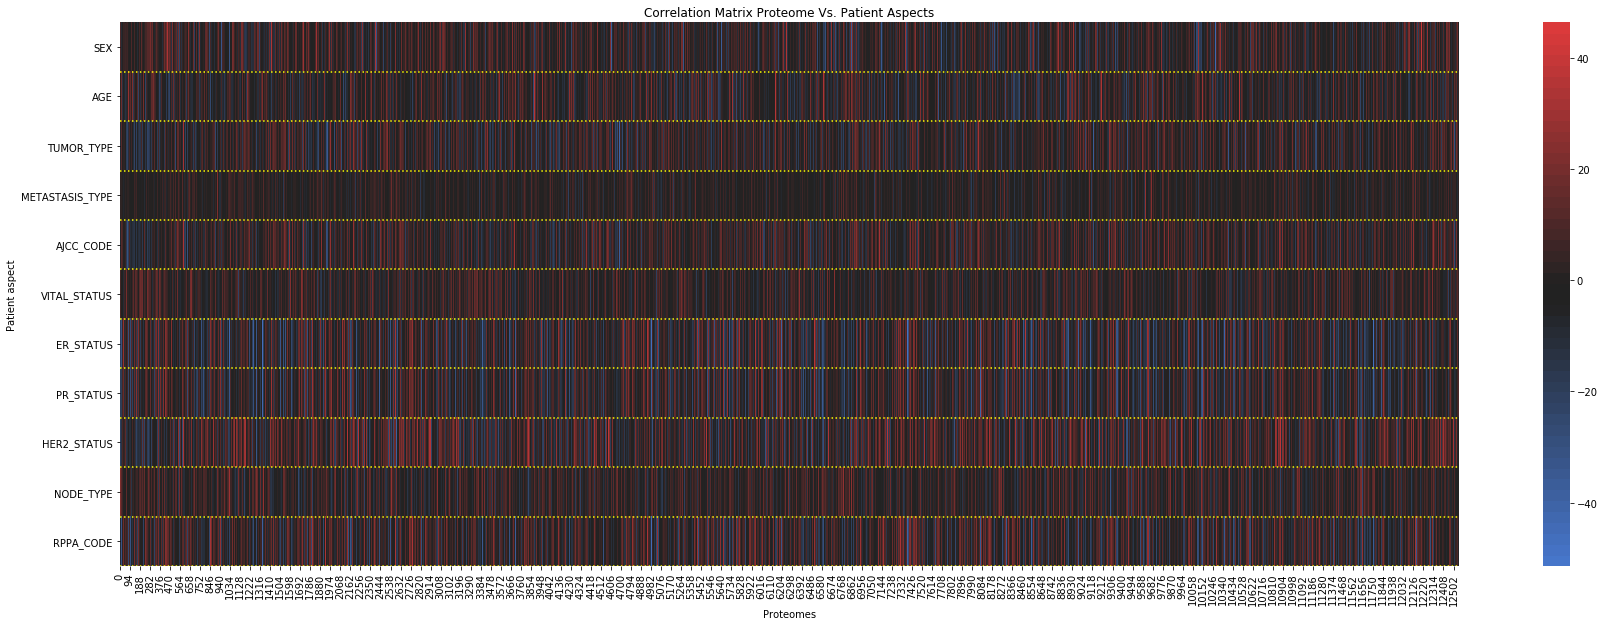

In [37]:
#plot matrix
fig, ax = plt.subplots(figsize=(30,10))
yticks=['SEX','AGE','TUMOR_TYPE','METASTASIS_TYPE','AJCC_CODE','VITAL_STATUS','ER_STATUS','PR_STATUS','HER2_STATUS','NODE_TYPE','RPPA_CODE']
ax = sns.heatmap(corrMatrix, cmap=sns.diverging_palette(255 , 12, l=50, n=50, center="dark"), ax=ax)
ax.set_yticklabels(yticks,rotation='horizontal')
ax.hlines([1, 2, 3,4,5,6,7,8,9,10,11], *ax.get_xlim(),linestyles='dotted',color='yellow')
ax.set_title('Correlation Matrix Proteome Vs. Patient Aspects')
ax.set_xlabel('Proteomes')
ax.set_ylabel('Patient aspect')
plt.show()

## I analize correlation to find elements more correlated (absolutly)

In [38]:
corr_sum=np.sum(corrMatrix**2,axis=1).tolist()

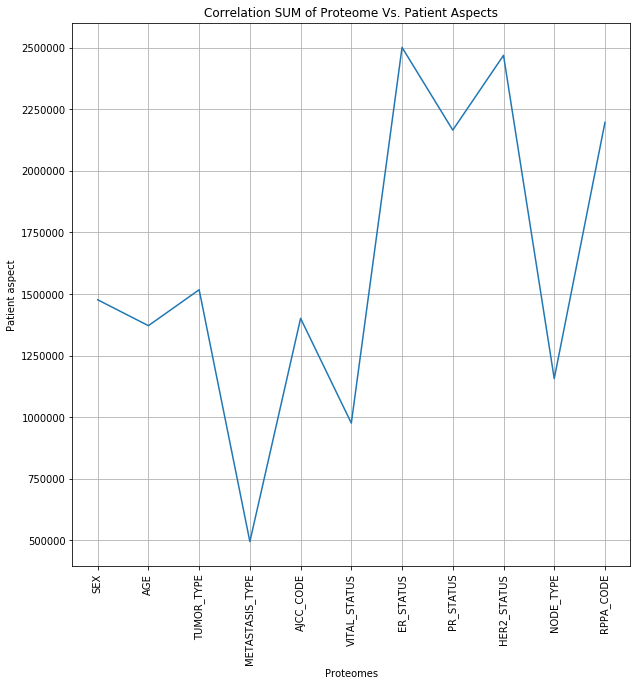

In [39]:
xticks=['SEX','AGE','TUMOR_TYPE','METASTASIS_TYPE','AJCC_CODE','VITAL_STATUS','ER_STATUS','PR_STATUS','HER2_STATUS','NODE_TYPE','RPPA_CODE']
gfig1, ax1 = plt.subplots(figsize=(10,10))
ax1.set_xticks(np.arange(11))
ax1.set_xticklabels(xticks,rotation='vertical')
plt.plot(corr_sum)
plt.grid()
ax1.set_title('Correlation SUM of Proteome Vs. Patient Aspects')
ax1.set_xlabel('Proteomes')
ax1.set_ylabel('Patient aspect')
plt.show()

In [40]:
corrMatrixPandas=pd.DataFrame(data=corrMatrix,index=xticks, columns=list(genePandasMatrix.columns.values))
corrMatrixPandas.index.name='Patient_aspect'
corrMatrixPandas.head()

,NP_000005-A2M (alpha-2-macroglobulin precursor),"NP_000007-ACADM (medium-chain specific acyl-CoA dehydrogenase, mitochondrial isoform a precursor)","NP_000008-ACADS (short-chain specific acyl-CoA dehydrogenase, mitochondrial precursor)","NP_000009-ACADVL (very long-chain specific acyl-CoA dehydrogenase, mitochondrial isoform 1 precursor)","NP_000010-ACAT1 (acetyl-CoA acetyltransferase, mitochondrial precursor)",NP_000012-PSEN1 (presenilin-1 isoform I-467),NP_000013-ADA (adenosine deaminase),NP_000017-ADSL (adenylosuccinate lyase isoform a),NP_000018-AGA (N(4)-(beta-N-acetylglucosaminyl)-L-asparaginase isoform 1 preproprotein),NP_000019-AGL (glycogen debranching enzyme isoform 1),...,XP_370934-# (PREDICTED: uncharacterized protein LOC388210),XP_373042-# (PREDICTED: uncharacterized protein LOC391722),XP_373277-# (PREDICTED: uncharacterized protein LOC392288),YP_003024026-ND1 (NADH dehydrogenase subunit 1),YP_003024028-COX1 (cytochrome c oxidase subunit I),YP_003024029-COX2 (cytochrome c oxidase subunit II),YP_003024030-# (ATP synthase F0 subunit 8),YP_003024031-# (ATP synthase F0 subunit 6),YP_003024032-# (cytochrome c oxidase subunit III),YP_003024036-ND5 (NADH dehydrogenase subunit 5)
Patient_aspect,,,,,,,,,,,,,,,,,,,,,
SEX,16.602742,2.121780,-5.073627,10.686839,4.023195,4.123544,15.306438,-9.524286,3.617290,-10.909775,...,-3.361621,18.778957,18.567636,-25.297825,0.015021,4.588781,0.210776,-0.841437,14.860017,-3.039611
AGE,2.404835,12.685898,11.622723,29.633851,22.492355,-13.196336,11.299540,-23.599359,-4.243710,-16.591530,...,-19.297394,-8.635258,-18.685695,1.871396,-0.214392,2.941978,6.166639,6.915705,0.673015,4.195698
TUMOR_TYPE,-23.529321,-13.887742,-19.461826,-14.680809,-11.939895,3.326297,-20.935546,-2.115196,-7.451857,-1.851950,...,0.662656,10.357320,-12.716157,4.153041,2.600984,4.983703,-7.289100,-4.109397,4.838092,-2.364530
METASTASIS_TYPE,3.274255,6.598231,0.727807,2.028007,14.253442,2.477836,6.907173,-6.280186,0.004961,-11.240175,...,1.680811,-8.371299,-1.972679,-4.186825,-8.892850,-0.263120,15.067820,-10.204572,2.299954,1.519805
AJCC_CODE,-20.462088,-16.372626,-18.427114,-9.478435,-6.775517,8.472941,-12.313073,-1.678848,-2.926693,1.430767,...,10.495535,0.472223,-5.200622,0.346151,-2.237492,9.201573,-0.309080,-14.037334,8.739224,-3.877265


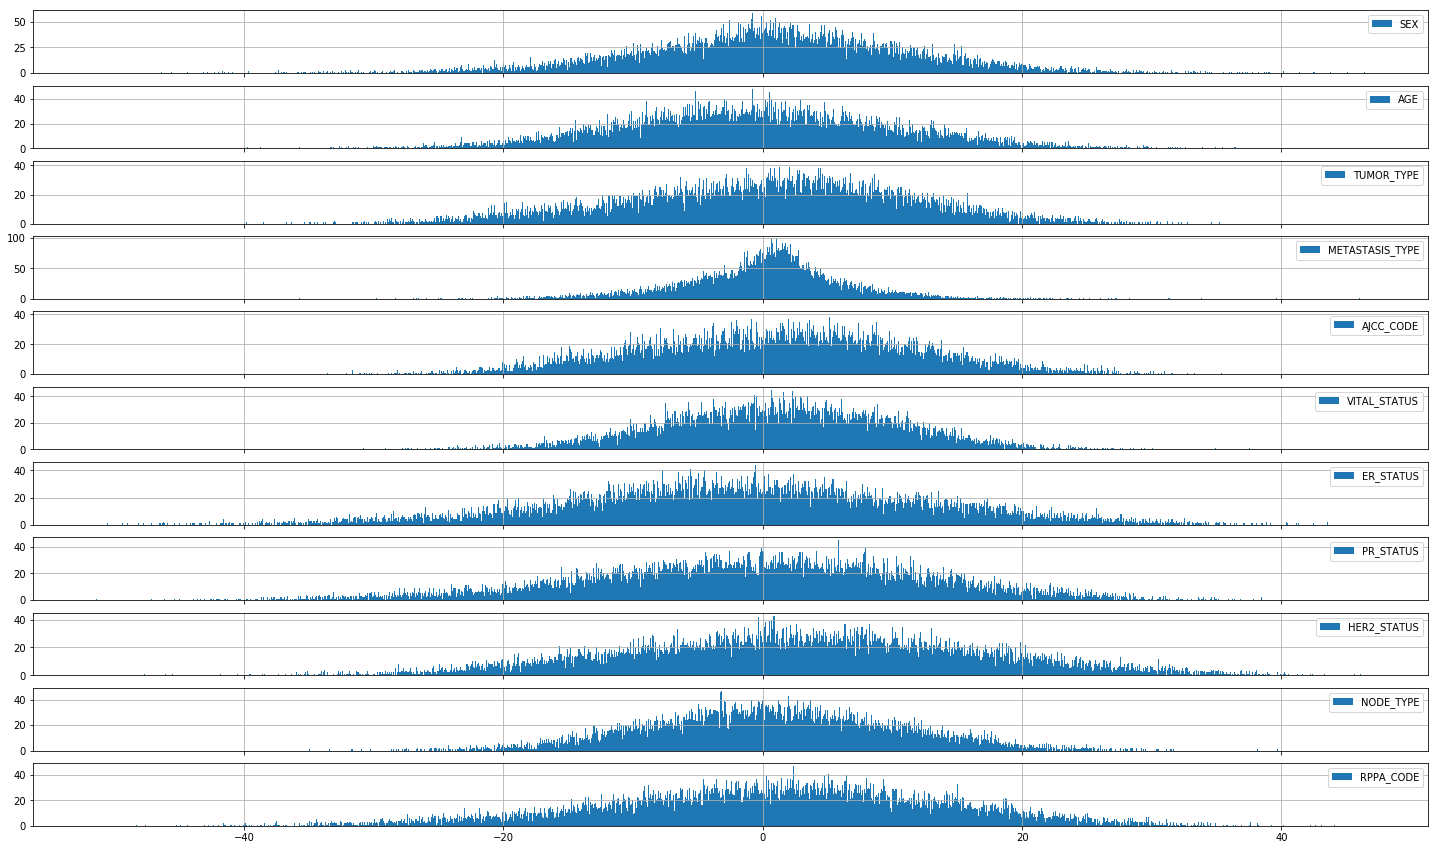

In [41]:
fig, axes = plt.subplots(nrows=len(corrMatrixPandas), sharex=True,figsize=(25,15))
k=0
for i, data in corrMatrixPandas.iterrows():
    dataArray=np.asarray(data.values.tolist())
    theLabel=corrMatrixPandas.index[k]
    axes[k].hist(dataArray, label=theLabel,bins = 1200) 
    axes[k].legend()
    axes[k].grid()
    k=k+1
plt.show()  

In [44]:
df3d=corrMatrixPandas.unstack().reset_index() # Transform in 3 column rapresentation
df3d.columns=["Proteome","Aspect","Correlation"]
df3d.head()

,Proteome,Aspect,Correlation
0,NP_000005-A2M (alpha-2-macroglobulin precursor...,SEX,16.602742
1,NP_000005-A2M (alpha-2-macroglobulin precursor...,AGE,2.404835
2,NP_000005-A2M (alpha-2-macroglobulin precursor...,TUMOR_TYPE,-23.529321
3,NP_000005-A2M (alpha-2-macroglobulin precursor...,METASTASIS_TYPE,3.274255
4,NP_000005-A2M (alpha-2-macroglobulin precursor...,AJCC_CODE,-20.462088


In [45]:
# I save correlation data in CSV format with ; separator directly in Cloud Object Storage
#i will use them for 3d Network graph visualization
project.save_data(data=df3d.to_csv(index=False, sep=';', encoding='utf-8'),file_name='CorrelationData.csv',overwrite=True)

{'asset_id': 'f3f4b894-ff62-4369-9f3d-19ecd400368f',
 'bucket_name': 'breastcancerproteomes-donotdelete-pr-zmcmbnmwpo1wza',
 'file_name': 'CorrelationData.csv',
 'message': 'File CorrelationData.csv has been written successfully to the associated OS'}

In [46]:
df3d.columns=["X","Y","Z"]
mask = abs(df3d['Z']) < 35 #limit onli high correlation
df3d.loc[mask, 'Z'] = 0
df3d['X']=pd.Categorical(df3d['X']) #convert label in integer number decoded for X and Y
df3d['X']=df3d['X'].cat.codes
df3d['Y']=pd.Categorical(df3d['Y'])
df3d['Y']=df3d['Y'].cat.codes
df3d.head()

,X,Y,Z
0,0,8,0.0
1,0,0,0.0
2,0,9,0.0
3,0,4,0.0
4,0,1,0.0


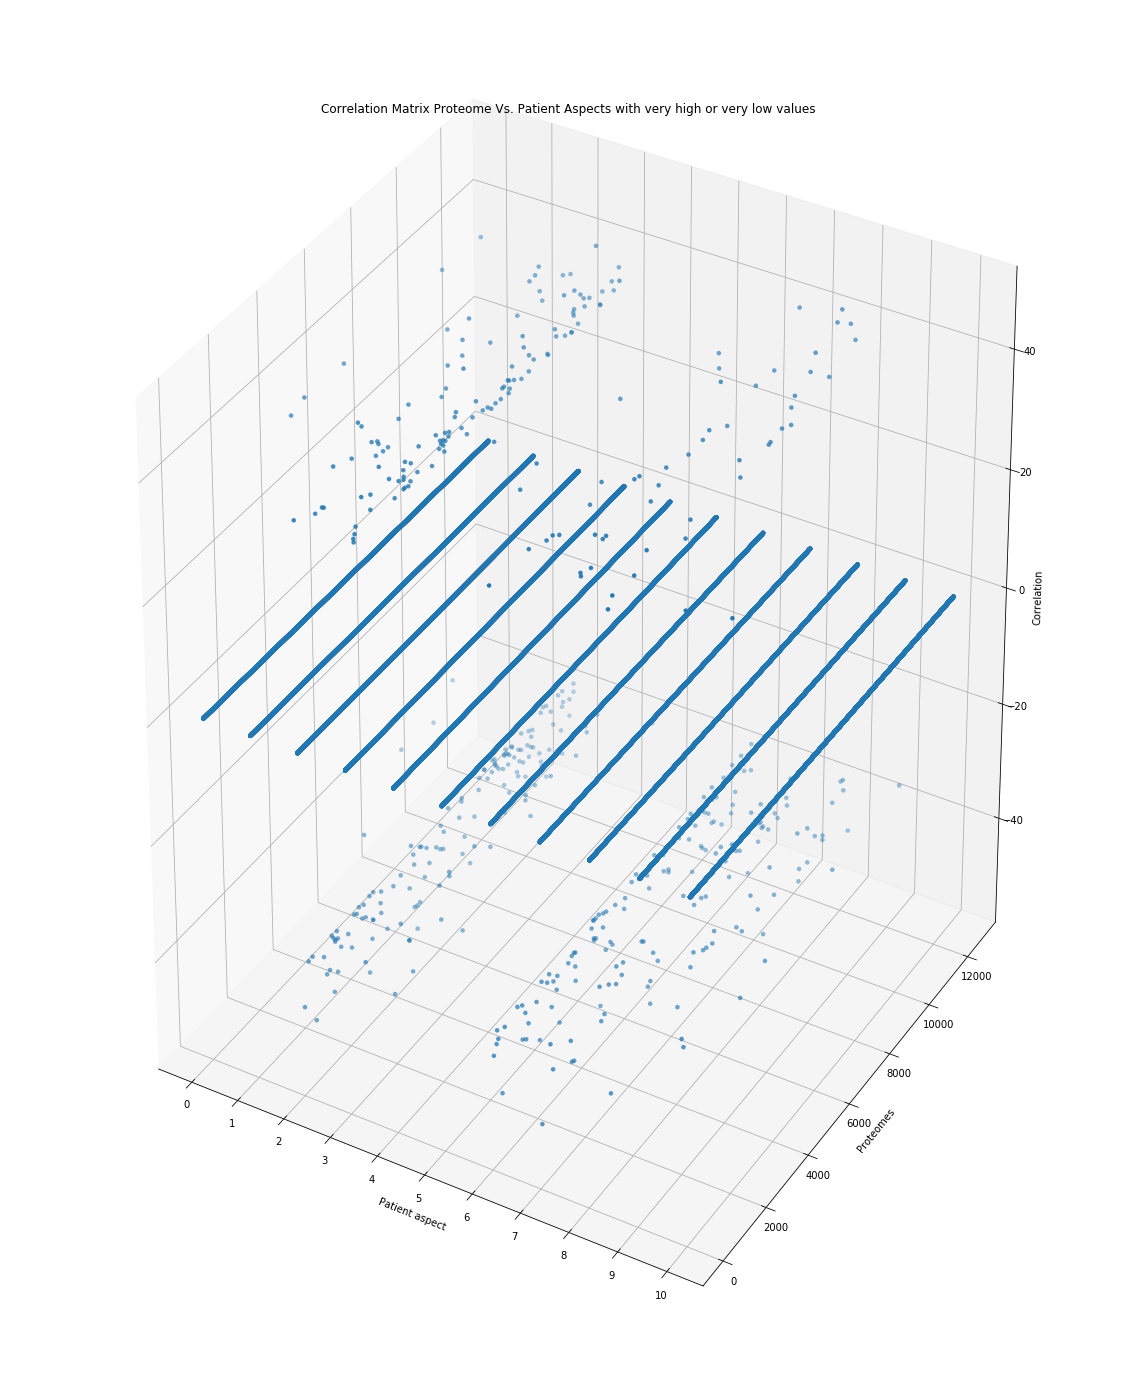

In [47]:
# Correlation matrix in 3D only for very high or very low correlations (abs value > 35)
fig = plt.figure(figsize=(20,25))
ax = fig.gca(projection='3d')
surf=ax.scatter(df3d['Y'], df3d['X'], df3d['Z'], cmap=plt.cm.jet, linewidth=0.05)
#fig.colorbar( surf, shrink=0.5, aspect=5)
ax.set_title('Correlation Matrix Proteome Vs. Patient Aspects with very high or very low values')
ax.set_xticks(np.arange(11))
ax.set_xlabel('Patient aspect')
ax.set_ylabel('Proteomes')
ax.set_zlabel('Correlation')
plt.show()

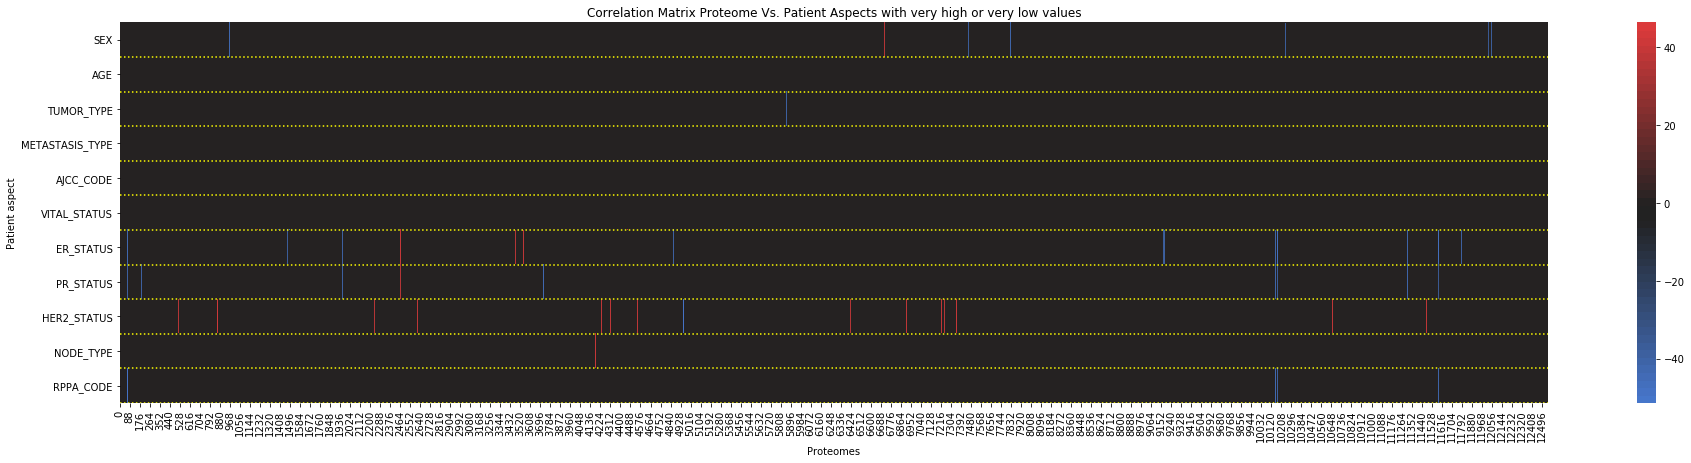

In [48]:
#plot matrix FILTERED
corrMatrix1=np.where(abs(corrMatrix)<35, 0,corrMatrix)
fig, ax = plt.subplots(figsize=(32,7))
yticks=['SEX','AGE','TUMOR_TYPE','METASTASIS_TYPE','AJCC_CODE','VITAL_STATUS','ER_STATUS','PR_STATUS','HER2_STATUS','NODE_TYPE','RPPA_CODE']
ax = sns.heatmap(corrMatrix1, cmap=sns.diverging_palette(255 , 12, l=50, n=50, center="dark"), ax=ax)
ax.set_yticklabels(yticks,rotation='horizontal')
ax.hlines([1, 2, 3,4,5,6,7,8,9,10,11], *ax.get_xlim(),linestyles='dotted',color='yellow')
ax.set_title('Correlation Matrix Proteome Vs. Patient Aspects with very high or very low values')
ax.set_xlabel('Proteomes')
ax.set_ylabel('Patient aspect')
plt.show()

__CONCLUSION__:
There are 3 patient's aspects ('ER_STATUS','PR_STATUS','HER2_STATUS') that are strongly correlated with Proteomes value. Looking at correlation values distributions seems that those 3 aspects have more extremal high strong positive correlation and low strong anti correlation with a relatively small number of proteomes.
I will build a new dataframe with this form:
> A number of row equal to patient and index column is patient ID <br>
> First 3 column are 'ER_STATUS','PR_STATUS','HER2_STATUS' NOT normalized and original values <br>
> Next columns are original proteomes value corresponding to very high or very low correlations present in corrMatrixPandas. I arbitrary will try with a __threshold correlation equal 35__  <br>

I will export this dataframe in CSV to use it to build a ML estimator

# With filtered data i build a ML dataset with dependent variable (i.e. patients caracteristics) and independent variable (i.e. proteomes normalizaed values for strongly correlated proteomes) to use in a ML modeling

In [49]:
# i obtain the patient list (original) ONLY with the 3 aspect of interest sorted by patient
col_list=['Complete TCGA ID','ER Status','PR Status','HER2 Final Status']
patientDataML=pd.DataFrame(patientData, columns=col_list)
patientDataML.set_index('Complete TCGA ID')
patientDataML.rename(columns={'Complete TCGA ID': 'Patient_ID'}, inplace=True)
patientDataML.rename(columns={'ER Status': 'ER_Status'}, inplace=True)
patientDataML.rename(columns={'PR Status': 'PR_Status'}, inplace=True)
patientDataML.rename(columns={'HER2 Final Status': 'HER2_Final_Status'}, inplace=True)
patientDataML.head()

,Patient_ID,ER_Status,PR_Status,HER2_Final_Status
1,TCGA-A2-A0CM,Negative,Negative,Negative
7,TCGA-A2-A0D0,Negative,Negative,Negative
28,TCGA-A2-A0D1,Negative,Negative,Positive
10,TCGA-A2-A0D2,Negative,Negative,Negative
31,TCGA-A2-A0EQ,Negative,Negative,Positive


In [50]:
normalizedPatientDataML = spark.sql("SELECT DISTINCT trim(PATIENT_ID) as PP FROM GENOMEDATA AS B ")
normalizedPatientDataML.show()

+------------+
|          PP|
+------------+
|TCGA-AO-A12E|
|TCGA-D8-A142|
|TCGA-A2-A0D2|
|TCGA-AR-A0TV|
|TCGA-A2-A0YM|
|TCGA-A2-A0SX|
|TCGA-E2-A158|
|TCGA-A8-A076|
|TCGA-BH-A0C1|
|TCGA-AN-A0FL|
|TCGA-AN-A0AL|
|TCGA-AR-A0U4|
|TCGA-C8-A12L|
|TCGA-A2-A0EY|
|TCGA-AN-A0FK|
|TCGA-BH-A0C7|
|TCGA-BH-A0BV|
|TCGA-AR-A1AW|
|TCGA-AR-A0TT|
|TCGA-BH-A18Q|
+------------+
only showing top 20 rows



In [51]:
#i generate the list of patient
patient_list=normalizedPatientDataML.toPandas()['PP'].values.tolist()
print(len(patient_list))

77


In [52]:
print(patient_list)

['TCGA-D8-A142', 'TCGA-AO-A12E', 'TCGA-A2-A0D2', 'TCGA-AR-A0TV', 'TCGA-A2-A0YM', 'TCGA-A2-A0SX', 'TCGA-E2-A158', 'TCGA-A8-A076', 'TCGA-BH-A0C1', 'TCGA-AN-A0FL', 'TCGA-AN-A0AL', 'TCGA-AR-A0U4', 'TCGA-C8-A12L', 'TCGA-A2-A0EY', 'TCGA-AN-A0FK', 'TCGA-BH-A0BV', 'TCGA-BH-A0C7', 'TCGA-AR-A1AW', 'TCGA-AR-A0TT', 'TCGA-BH-A18Q', 'TCGA-A8-A079', 'TCGA-AN-A04A', 'TCGA-A2-A0YF', 'TCGA-BH-A0DD', 'TCGA-BH-A0AV', 'TCGA-C8-A12T', 'TCGA-BH-A0DG', 'TCGA-HEALTY1', 'TCGA-BH-A18N', 'TCGA-C8-A134', 'TCGA-AR-A1AS', 'TCGA-AO-A0JL', 'TCGA-A2-A0EX', 'TCGA-A2-A0T6', 'TCGA-A8-A09G', 'TCGA-C8-A130', 'TCGA-E2-A154', 'TCGA-BH-A0E9', 'TCGA-AN-A0AJ', 'TCGA-A7-A0CE', 'TCGA-C8-A135', 'TCGA-A8-A06Z', 'TCGA-A2-A0EQ', 'TCGA-A2-A0T3', 'TCGA-AO-A0JE', 'TCGA-AR-A0TX', 'TCGA-A7-A0CJ', 'TCGA-E2-A15A', 'TCGA-AO-A126', 'TCGA-HEALTY2', 'TCGA-A2-A0YC', 'TCGA-AO-A12F', 'TCGA-BH-A18U', 'TCGA-C8-A138', 'TCGA-AR-A0TR', 'TCGA-HEALTY3', 'TCGA-C8-A12V', 'TCGA-AO-A0JM', 'TCGA-A2-A0YG', 'TCGA-A2-A0YD', 'TCGA-AO-A0JC', 'TCGA-AN-A0AM', 'TCGA-C

In [53]:
# then i select patients with this list
patientDataML1=patientDataML.loc[patientDataML['Patient_ID'].isin(patient_list)]
patientDataML1.shape

(74, 4)

In [54]:
# i obtain the correlation matrix daframe ONLY for the 3 aspect of interest
corrMatrixPandasML=pd.DataFrame(corrMatrixPandas)
corrMatrixPandasML.drop(['SEX','AGE','TUMOR_TYPE','METASTASIS_TYPE','AJCC_CODE','VITAL_STATUS','NODE_TYPE','RPPA_CODE'],inplace=True)
corrMatrixPandasML.shape

(3, 12553)

In [55]:
# and then i transpose it
corrMatrixPandasML_T=corrMatrixPandasML.transpose()
corrMatrixPandasML_T.shape

(12553, 3)

In [56]:
# i apply the selection over correlation value
c1=corrMatrixPandasML_T['ER_STATUS']>35 
c2=corrMatrixPandasML_T['PR_STATUS']>35
c3=corrMatrixPandasML_T['HER2_STATUS']>35
c4=corrMatrixPandasML_T['ER_STATUS']<-35 
c5=corrMatrixPandasML_T['PR_STATUS']<-35
c6=corrMatrixPandasML_T['HER2_STATUS']<-35
corrMatrixPandasML_T_selected=corrMatrixPandasML_T[c1|c2|c3|c4|c5|c6] #bitwise or
corrMatrixPandasML_T_selected.shape

(297, 3)

In [57]:
# then i obtain the list of interesting proteomes
proteomes_list=[x.strip() for x in list(corrMatrixPandasML_T_selected.index)]
print(len(proteomes_list))

297


In [58]:
reshapedData.head()

,RefSeq_accession_number,gene_symbol,gene_name,Patient,Value,Gene,Patient_ID
0,NP_958782,PLEC,plectin isoform 1,AO-A12D.01TCGA,1.096131,NP_958782-PLEC (plectin isoform 1),TCGA-AO-A12D
1,NP_958785,NaN,plectin isoform 1g,AO-A12D.01TCGA,1.111370,NP_958785-# (plectin isoform 1g),TCGA-AO-A12D
2,NP_958786,PLEC,plectin isoform 1a,AO-A12D.01TCGA,1.111370,NP_958786-PLEC (plectin isoform 1a),TCGA-AO-A12D
3,NP_000436,NaN,plectin isoform 1c,AO-A12D.01TCGA,1.107561,NP_000436-# (plectin isoform 1c),TCGA-AO-A12D
4,NP_958781,NaN,plectin isoform 1e,AO-A12D.01TCGA,1.115180,NP_958781-# (plectin isoform 1e),TCGA-AO-A12D


In [59]:
#now i take again the original reshaped data  and filter both for patient_list both for proteomes list
reshapedData1=reshapedData.loc[reshapedData['Patient_ID'].isin(patient_list)]
reshapedData2=reshapedData1.loc[reshapedData1['Gene'].isin(proteomes_list)]
reshapedData2.shape

(21978, 7)

In [60]:
# i eliminate unwanted column
reshapedData3=reshapedData2.drop(['RefSeq_accession_number','gene_symbol','gene_name','Patient'],axis=1)
reshapedData3.set_index('Patient_ID')
reshapedData3.head()

,Value,Gene,Patient_ID
37668,-0.517226,NP_001611-AHNAK (neuroblast differentiation-as...,TCGA-BH-A18Q
37777,-0.122471,NP_003283-TPR (nucleoprotein TPR),TCGA-BH-A18Q
37809,-2.470929,NP_006717-LRBA (lipopolysaccharide-responsive ...,TCGA-BH-A18Q
37810,-2.470929,NP_001186211-# (lipopolysaccharide-responsive ...,TCGA-BH-A18Q
37934,-0.333230,"NP_065871-PREX1 (phosphatidylinositol 3,4,5-tr...",TCGA-BH-A18Q


In [61]:
#verify usage of ',' caracter because in CSV export this will be a problema. If presente i need to substitute
coma_count=reshapedData3['Gene'].str.contains(',').sum()
print (coma_count)

1480


In [62]:
# SOB is present
reshapedData3['Gene']=reshapedData3['Gene'].str.replace(',','|') # i replace
coma_count=reshapedData3['Gene'].str.contains(',').sum() #then count again
print (coma_count)

0


In [63]:
# then i pivot again the data
ML_valueMatrix=reshapedData3.pivot(index='Patient_ID', columns='Gene')['Value']
ML_valueMatrix.shape

(74, 297)

In [64]:
#i cannot merge or join pandas dataframe due to types of data (int64 and string) so i need to convert pandas into spark dataframe, create temp table and then make a sql join (SOB !!!!)
sqlContext = SQLContext(sc)
spark_ML_valueMatrix = sqlContext.createDataFrame(ML_valueMatrix.reset_index(drop=False))
spark_patientDataML1 = sqlContext.createDataFrame(patientDataML1)
spark_ML_valueMatrix.createOrReplaceTempView("proteome")
spark_patientDataML1.createOrReplaceTempView("patient")

In [65]:
ML_valueMatrix.head()

Gene,NP_000024-ABCD1 (ATP-binding cassette sub-family D member 1),NP_000095-CYP1B1 (cytochrome P450 1B1),NP_000116-ESR1 (estrogen receptor),NP_000311-QDPR (dihydropteridine reductase),NP_000366-UROS (uroporphyrinogen-III synthase),NP_000447-SUOX (sulfite oxidase| mitochondrial),NP_000917-PGR (progesterone receptor isoform B),NP_001001520-HDGFRP2 (hepatoma-derived growth factor-related protein 2 isoform 1),NP_001001683-MED11 (mediator of RNA polymerase II transcription subunit 11),NP_001002295-GATA3 (trans-acting T-cell-specific transcription factor GATA-3 isoform 1),...,NP_821068-PPP2R4 (serine/threonine-protein phosphatase 2A activator isoform a),NP_839946-HAPLN3 (hyaluronan and proteoglycan link protein 3 precursor),NP_872293-OLFML2A (olfactomedin-like protein 2A precursor),NP_899228-# (neuroblastoma breakpoint family member 11),NP_938051-TTC8 (tetratricopeptide repeat protein 8 isoform B),NP_938052-TTC8 (tetratricopeptide repeat protein 8 isoform C),NP_945353-ARHGEF1 (rho guanine nucleotide exchange factor 1 isoform 1),NP_976225-ZRANB2 (zinc finger Ran-binding domain-containing protein 2 isoform 1),NP_996667-PECI (enoyl-CoA delta isomerase 2| mitochondrial isoform 2),NP_996668-OSCP1 (protein OSCP1 isoform 2)
Patient_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,1.572395,2.244648,-4.937078,-2.350922,-1.597851,-3.625632,-6.509343,-0.727227,0.980958,-5.726884,...,-0.617022,0.720139,1.197696,-0.084362,-1.333357,-1.333357,1.256472,0.238908,-4.540338,-2.655824
TCGA-A2-A0D2,-2.680044,0.343666,-4.153646,-2.380667,-1.835135,-2.623495,-5.287953,-1.811850,-1.066733,-4.343251,...,-1.875052,6.680486,-0.634299,NaN,-1.176505,-1.396048,1.201881,-0.225151,-3.867574,-2.443869
TCGA-A2-A0EQ,-1.019829,-0.487863,-6.308873,-1.134642,-0.698353,-2.435854,-7.047502,-0.162560,-1.146123,1.161615,...,0.369406,1.456301,NaN,-2.814736,-0.897362,NaN,1.027667,-0.001822,-1.965121,-1.364267
TCGA-A2-A0EV,-1.319794,2.634654,0.649028,0.032896,0.878677,1.727259,-1.266583,-3.134584,-0.877299,-1.151758,...,-0.871698,0.055301,-0.196753,NaN,1.214749,0.931889,0.719043,-3.899148,-0.118337,-2.297204
TCGA-A2-A0EX,-1.625035,1.601565,-2.409174,-1.122286,1.005019,0.543540,1.545287,0.115828,0.738637,0.742389,...,0.258399,2.314418,2.745882,3.034776,1.132582,1.909217,0.671103,0.059550,-2.679308,0.419729


In [66]:
patientDataML1.head()

,Patient_ID,ER_Status,PR_Status,HER2_Final_Status
1,TCGA-A2-A0CM,Negative,Negative,Negative
10,TCGA-A2-A0D2,Negative,Negative,Negative
31,TCGA-A2-A0EQ,Negative,Negative,Positive
55,TCGA-A2-A0EV,Positive,Positive,Negative
61,TCGA-A2-A0EX,Positive,Positive,Negative


In [67]:
#I verify the number od CLASS/CLUSTER i had to analize in ML
NumebrOfClass = spark.sql("SELECT COUNT(*) as NUMCLAS FROM \
                          (SELECT DISTINCT concat(trim(B.ER_STATUS),'-',trim(B.ER_STATUS),'-',trim(B.HER2_Final_Status)) as STATUS \
                         FROM patient AS B) ")
NumebrOfClass.show()

+-------+
|NUMCLAS|
+-------+
|      5|
+-------+



In [68]:
finalMLData = spark.sql("SELECT concat(trim(B.ER_STATUS),'-',trim(B.ER_STATUS),'-',trim(B.HER2_Final_Status)) as STATUS, A.* \
                         FROM patient AS B, proteome AS A \
                         WHERE A.PATIENT_ID=B.PATIENT_ID")
finalMLDataPandas=finalMLData.toPandas()
finalMLDataPandas.drop(['Patient_ID'], axis=1,inplace=True)
finalMLDataPandas=finalMLDataPandas.fillna(0)
finalMLDataPandas.head()

,STATUS,NP_000024-ABCD1 (ATP-binding cassette sub-family D member 1),NP_000095-CYP1B1 (cytochrome P450 1B1),NP_000116-ESR1 (estrogen receptor),NP_000311-QDPR (dihydropteridine reductase),NP_000366-UROS (uroporphyrinogen-III synthase),NP_000447-SUOX (sulfite oxidase| mitochondrial),NP_000917-PGR (progesterone receptor isoform B),NP_001001520-HDGFRP2 (hepatoma-derived growth factor-related protein 2 isoform 1),NP_001001683-MED11 (mediator of RNA polymerase II transcription subunit 11),...,NP_821068-PPP2R4 (serine/threonine-protein phosphatase 2A activator isoform a),NP_839946-HAPLN3 (hyaluronan and proteoglycan link protein 3 precursor),NP_872293-OLFML2A (olfactomedin-like protein 2A precursor),NP_899228-# (neuroblastoma breakpoint family member 11),NP_938051-TTC8 (tetratricopeptide repeat protein 8 isoform B),NP_938052-TTC8 (tetratricopeptide repeat protein 8 isoform C),NP_945353-ARHGEF1 (rho guanine nucleotide exchange factor 1 isoform 1),NP_976225-ZRANB2 (zinc finger Ran-binding domain-containing protein 2 isoform 1),NP_996667-PECI (enoyl-CoA delta isomerase 2| mitochondrial isoform 2),NP_996668-OSCP1 (protein OSCP1 isoform 2)
0,Positive-Positive-Negative,0.997383,0.000000,-0.437821,-1.132362,1.602393,2.633352,-1.542032,0.229589,-0.223490,...,0.802043,-3.373341,-0.511073,0.00000,1.518288,1.518288,-0.568047,-1.075388,2.538395,2.866674
1,Negative-Negative-Negative,-1.200094,2.396572,-3.065300,-2.490557,-0.748252,-1.091652,-6.394476,-1.644707,-0.440999,...,-1.069964,2.447179,-0.773555,0.00000,-0.451843,-0.372319,0.835004,-1.485659,-3.549676,-3.856929
2,Negative-Negative-Negative,-2.680044,0.343666,-4.153646,-2.380667,-1.835135,-2.623495,-5.287953,-1.811850,-1.066733,...,-1.875052,6.680486,-0.634299,0.00000,-1.176505,-1.396048,1.201881,-0.225151,-3.867574,-2.443869
3,Positive-Positive-Negative,0.595190,-0.236831,3.573098,-0.881158,-0.822328,-0.934385,0.104942,1.110651,0.684836,...,0.032105,-0.189207,0.000000,-0.19481,0.648417,0.673630,-0.435732,1.189091,0.155367,0.799694
4,Negative-Negative-Negative,-0.165013,2.132485,-1.792980,0.731516,0.855333,1.930708,-2.377672,0.153702,0.000000,...,0.181217,1.531742,0.000000,0.00000,0.000000,0.000000,0.612284,-1.013390,-0.793270,0.000000


In [69]:
# And at the end i save data again in CSV format with ; separator
project.save_data(data=finalMLDataPandas.to_csv(index=False, sep=',', encoding='utf-8'),file_name='FinalDataForML.csv',overwrite=True)

{'asset_id': 'd8b970b6-f57f-4ddf-af2a-4467282227f4',
 'bucket_name': 'breastcancerproteomes-donotdelete-pr-zmcmbnmwpo1wza',
 'file_name': 'FinalDataForML.csv',
 'message': 'File FinalDataForML.csv has been written successfully to the associated OS'}

# This is anoter figurative section to remeber i use Watson ML service to build the classification/predictive model and expose it as REST API

Now i work with __ML Watson Service__ to build multiclass model using as *indipendent variable* the __STATUS__ column and as *parameter* the __298 proteomes__ with high correlation previously isulated. <br>
__I obtained a fair good decision tree estimator (71% positive positive answer) and i deloyed it as Web Services__

# To complete the journey i use sklearn library to rebuild here a decision tree and give a graphical presentation of it

In [70]:
! pip install --user --upgrade pydotplus

Requirement already up-to-date: pydotplus in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s2a1-a4a4fc7ce6bf65-e89a3fdacf4a/.local/lib/python3.5/site-packages
Requirement already up-to-date: pyparsing>=2.0.1 in /usr/local/src/conda3_runtime.v41/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from pydotplus)


In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [72]:
finalMLDataPandas.shape

(74, 298)

In [73]:
X = finalMLDataPandas.values[:, 1:298] # calculation variable
Y = finalMLDataPandas.values[:,0] #Feature

In [74]:
# then i calculate dtree
dtree = DecisionTreeClassifier(criterion = "gini", random_state = 100, min_samples_leaf=1)
dtree.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [75]:
feature_names_list=list(finalMLDataPandas.columns.values)
del feature_names_list[0] #delete first column that i the target and not a feature name

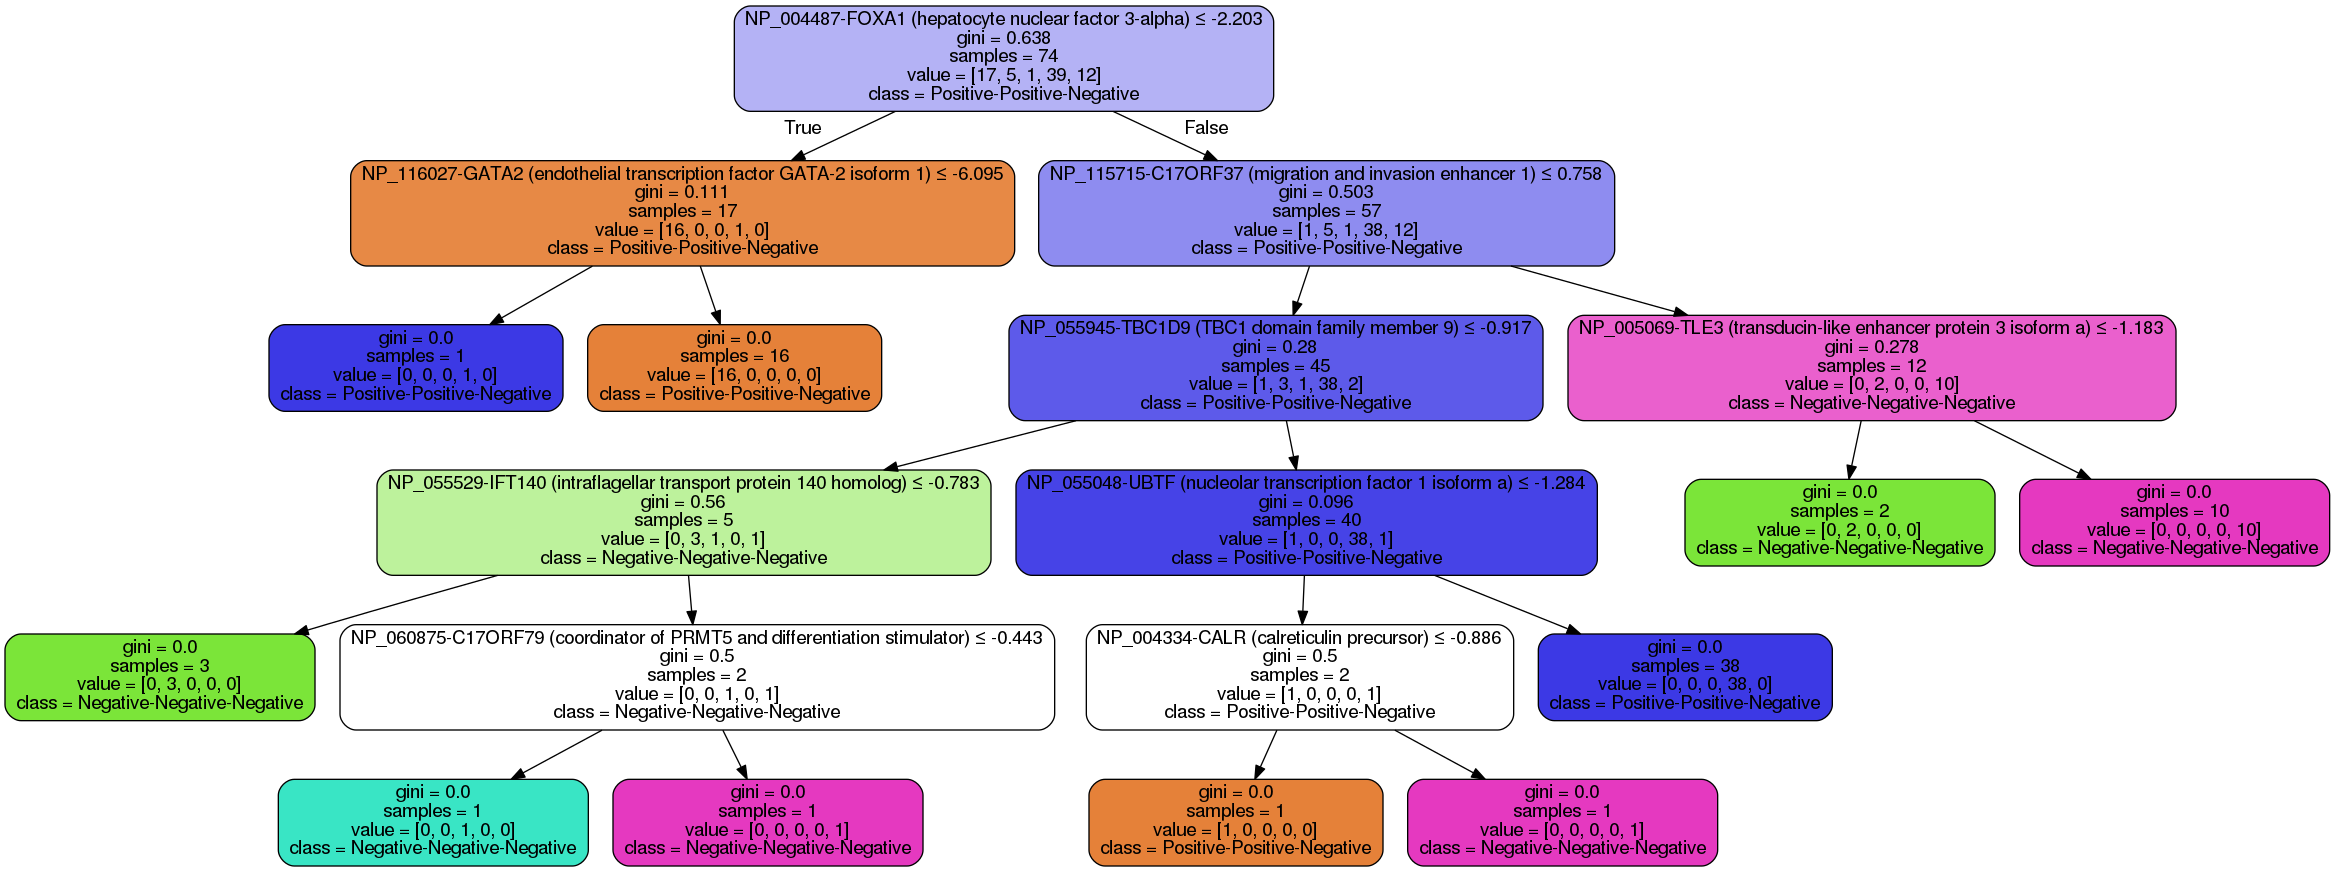

In [76]:
dot_data = StringIO()
export_graphviz(dtree, feature_names=feature_names_list, class_names=Y, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [77]:
# then i calculate dtree
dtree_ENT = DecisionTreeClassifier(criterion = "entropy", random_state = 100, min_samples_leaf=1)
dtree_ENT.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

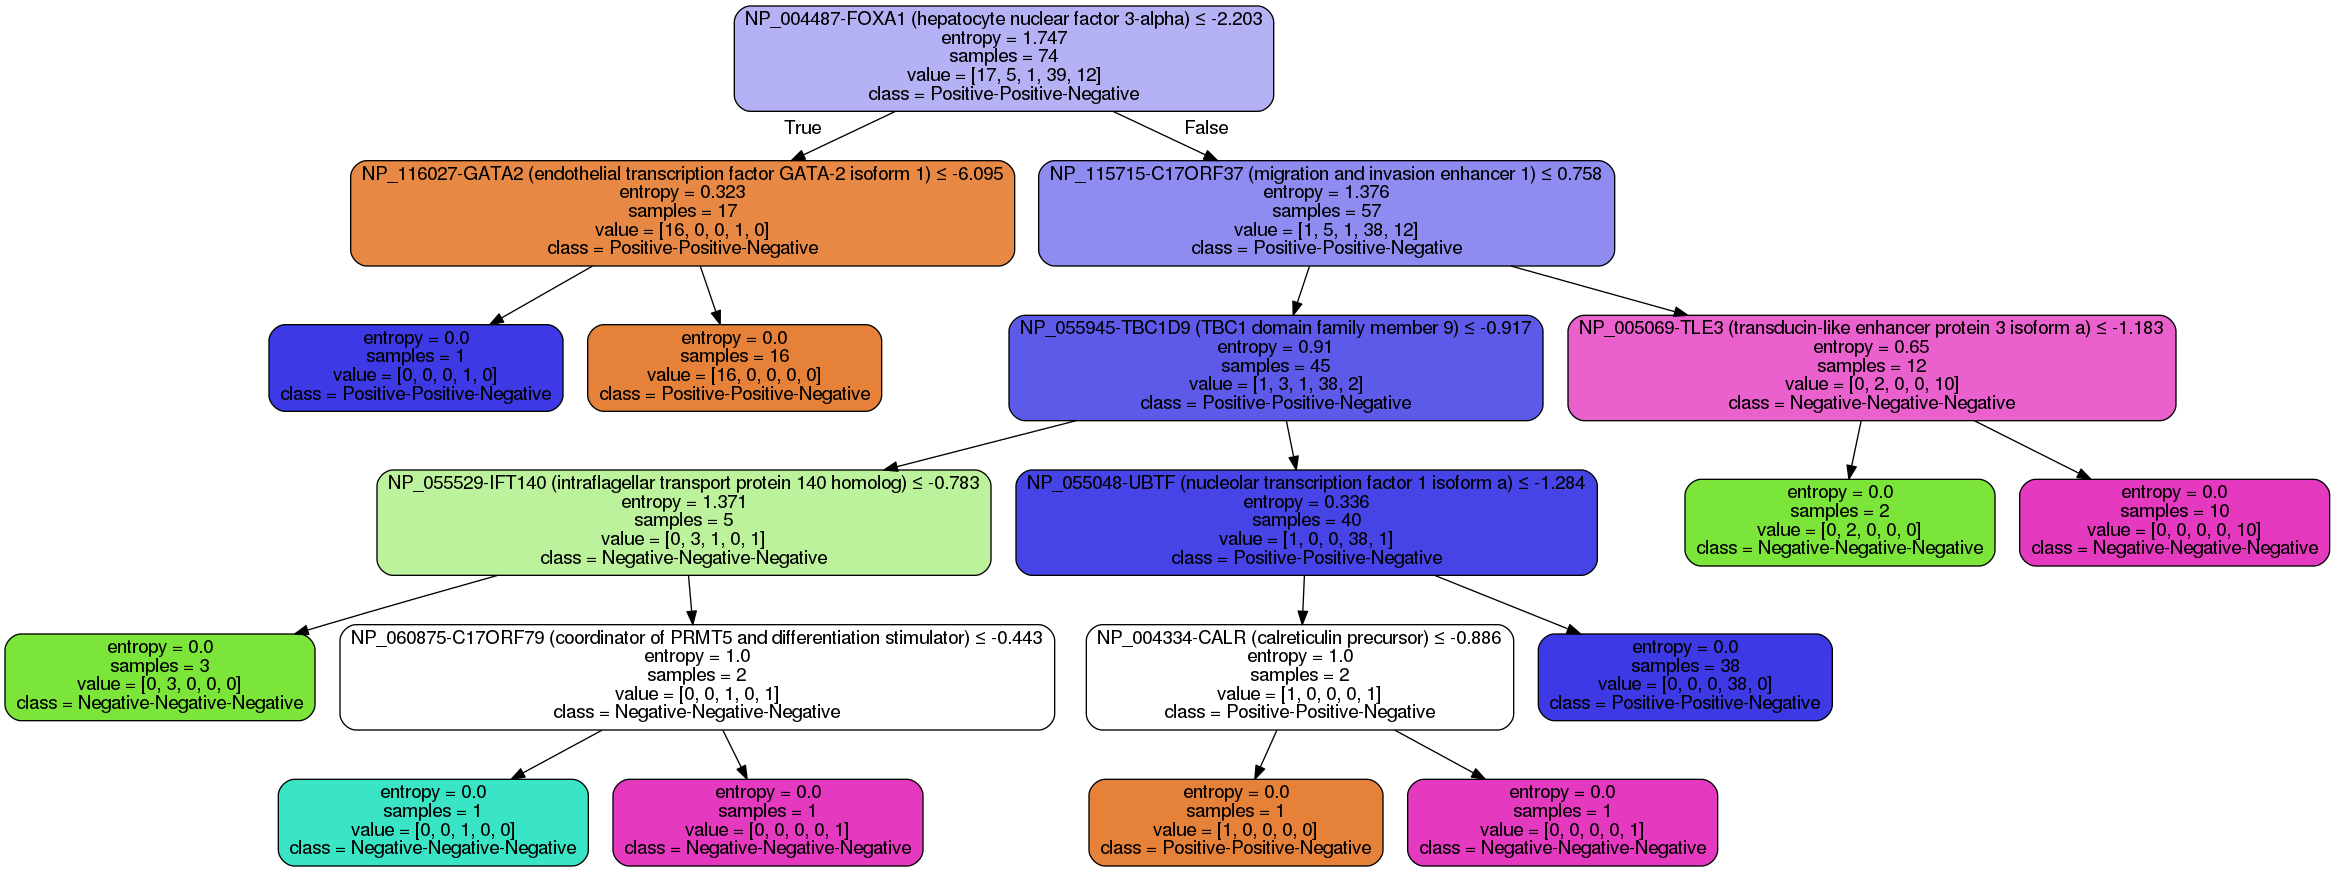

In [78]:
dot_data = StringIO()
export_graphviz(dtree_ENT, feature_names=feature_names_list, class_names=Y, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())